In [1]:
import numpy as np
from pylab import *
from scipy import ndimage
from scipy import misc
from scipy import linalg
from scipy import argsort
from scipy import signal
from scipy import interpolate
import os
import glob

import h5py as h5

%matplotlib inline

rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session

In [2]:
%load_ext autoreload
%autoreload 2

# Set up ND fiber angle code

In [3]:
import fibers

## Test autocorrelation

My implementation using FFTs

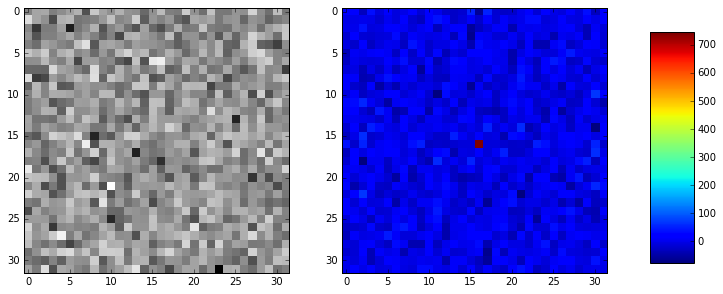

In [8]:
I1 = np.random.randn(32,32)
W = fibers.make_window_vals(I1,window='kaiser')
C = fibers.ndautocorr(I1,insz=(16,16),window=W)

fig,axes = subplots(1,2)

axes[0].imshow(I1,cmap=cm.gray, interpolation='nearest')

im = axes[1].imshow(C, interpolation='nearest')

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
fig.colorbar(im, cax=cax)

show()

Scipy implementation, also using FFTs

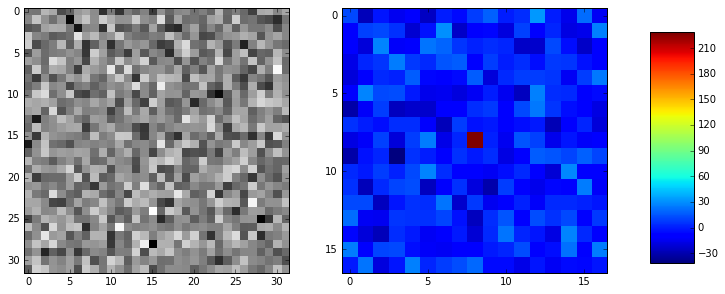

In [10]:
I1 = np.random.randn(32,32)
W = fibers.make_window_vals(I1,window='kaiser')
C = fibers.scipyautocorr(I1,insz=(16,16),window=W)

fig,axes = subplots(1,2)

axes[0].imshow(I1,cmap=cm.gray, interpolation='nearest')

im = axes[1].imshow(C, interpolation='nearest')

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
fig.colorbar(im, cax=cax)

show()

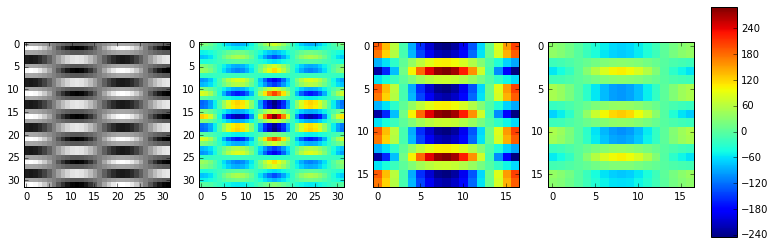

In [21]:
i,j = np.meshgrid(range(-16,16),range(-16,16))
I1 = np.sin(2*np.pi*i/20) * np.cos(2*np.pi*j/5)

hamm = fibers.make_window_vals(I1, window='hamming')

C0 = fibers.ndautocorr(I1)
C1 = fibers.scipyautocorr(I1,insz=(16,16))
C2 = fibers.scipyautocorr(I1,insz=(16,16),window=hamm)

fig,ax = subplots(1,4)
ax[0].imshow(I1,cmap=cm.gray, interpolation='nearest')

im = ax[1].imshow(C0, interpolation='nearest')
im.set_clim(np.min(C0),np.max(C0))

im = ax[2].imshow(C1, interpolation='nearest')
im.set_clim(np.min(C1),np.max(C1))

im = ax[3].imshow(C2, interpolation='nearest')
im.set_clim(np.min(C1),np.max(C1))

fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.3, 0.03, 0.4])
fig.colorbar(im, cax=cax)

show()

## Test with lines

In [19]:
def generate_line_image(sz,ang,k):
    szhi = sqrt(2)*sz
    
    a0 = np.arange(szhi)
    a0 = a0 - a0[-1]/2
    b0 = a0.copy()
    a,b = np.atleast_2d(a0,b0)
    b = b.T

    #need the np.ones_line so that it broadcasts and we get a matrix
    #that is [len(a),len(b)] in shape
    I0 = cos(2*pi*k/sz*b) * np.ones_like(a)
    
    i0 = np.arange(sz)
    i0 = i0 - i0[-1]/2
    j0 = i0.copy()
    i0,j0 = np.atleast_2d(i0,j0)
    i0 = i0.T
    
    i = i0*np.cos(ang) + j0*np.sin(ang)
    j = -i0*np.sin(ang) + j0*np.cos(ang)
    
    fcn = interpolate.RectBivariateSpline(a0,b0,I0)
    I = fcn(i,j,grid=False)
    
    return I,np.squeeze(i0),np.squeeze(j0)

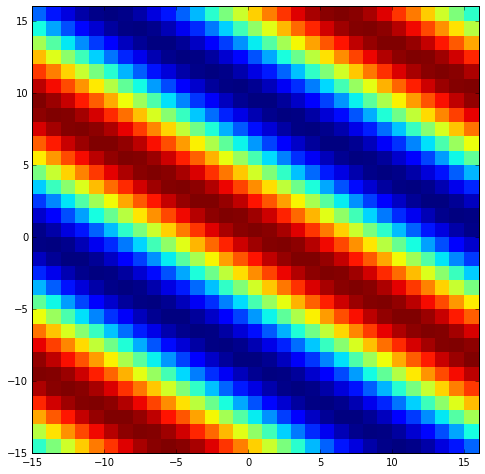

In [20]:
I,i,j = generate_line_image(32,30*np.pi/180, 2)
pcolormesh(i,j,I)
axis('square')
gca().autoscale(tight=True)
show()

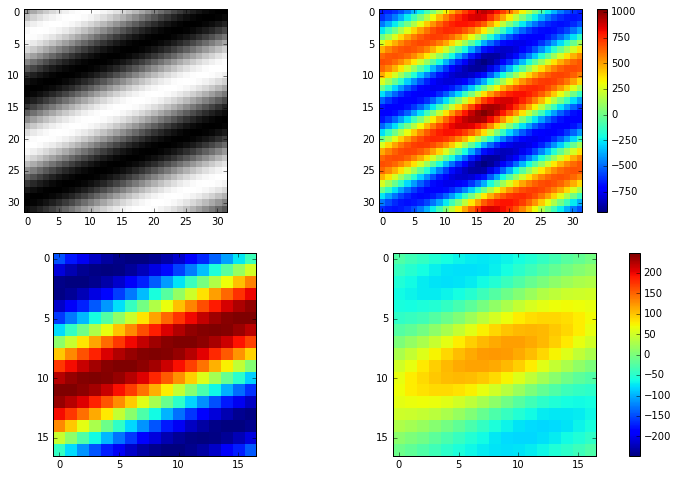

In [50]:
hamm = fibers.make_window_vals(I, window='hamming')

C1 = fibers.ndautocorr(I)
C2 = fibers.scipyautocorr(I,insz=(16,16))
C3 = fibers.scipyautocorr(I,insz=(16,16), window=hamm)

fig,ax = subplots(2,2)
ax[0,0].imshow(I,cmap=cm.gray, interpolation='nearest')

im = ax[0,1].imshow(C1, interpolation='nearest')
fig.colorbar(im, ax=ax[0,1])

im = ax[1,0].imshow(C2, interpolation='nearest')
im.set_clim(np.min(C2),np.max(C2))

im = ax[1,1].imshow(C3, interpolation='nearest')
im.set_clim(np.min(C2),np.max(C2))

fig.colorbar(im, ax=ax[1,:].tolist(), fraction=0.02)

show()

## Check line angle

[array([ -73.56126259, -229.96895264]), array([ -1.88483724, -21.07638777]), array([ -1.09415421, -31.46958425])]


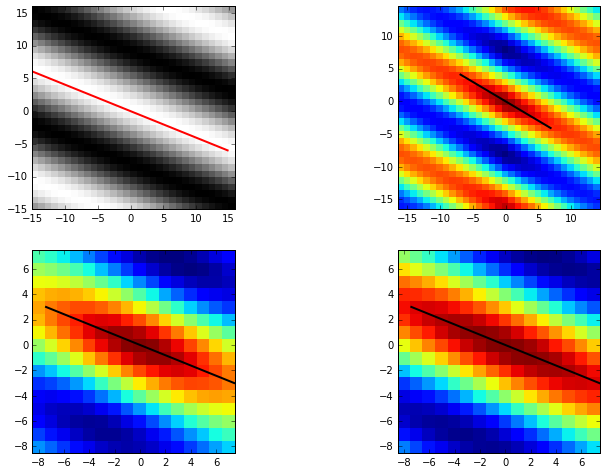

In [68]:
ang = 22*np.pi/180
I,i,j = generate_line_image(32,ang, 2)

#true angle
u0 = np.cos(-ang)
v0 = np.sin(-ang)

#autocorrelation
vr1,w1,C1 = fibers.fiber_angle(I, returncorr=True)
vr2,w2,C2 = fibers.fiber_angle(I,insz=(16,16), autocorrfcn=fibers.scipyautocorr, returncorr=True, 
                               window=fibers.make_window_vals(I,window='hamming'))
vr3,w3,C3 = fibers.fiber_angle(I,insz=(16,16), autocorrfcn=fibers.scipyautocorr, returncorr=True, 
                               window=fibers.make_window_vals(I,window='kaiser',beta=2))

a = np.arange(C2.shape[0]) - C2.shape[0]//2
b = np.arange(C2.shape[1]) - C2.shape[1]//2

fig,ax = subplots(2,2)
ax[0,0].pcolormesh(i,j,I,cmap=cm.gray)
ax[0,0].plot(16*np.array([-u0, u0]), 16*np.array([-v0,v0]), 'r-', linewidth=2.0)

ax[0,1].pcolormesh(i-1.5,j-1.5,C1)
ax[0,1].plot(8*np.array([-vr1[1,0], vr1[1,0]]), 8*np.array([-vr1[0,0],vr1[0,0]]), 'k-', linewidth=2.0)

ax[1,0].pcolormesh(a-0.5,b-0.5,C2)
ax[1,0].plot(8*np.array([-vr2[1,0], vr2[1,0]]), 8*np.array([-vr2[0,0],vr2[0,0]]), 'k-', linewidth=2.0)

ax[1,1].pcolormesh(a-0.5,b-0.5,C3)
ax[1,1].plot(8*np.array([-vr3[1,0], vr3[1,0]]), 8*np.array([-vr3[0,0],vr3[0,0]]), 'k-', linewidth=2.0)

for ax1 in ax.flat:
    ax1.set_aspect('equal')
    ax1.autoscale(tight=True)
    
print [np.real(w1),np.real(w2),np.real(w3)]

## Timing

In [71]:
%timeit vr1,w1 = fibers.fiber_angle(I)

1000 loops, best of 3: 321 µs per loop


In [74]:
%timeit vr2,w2 = fibers.fiber_angle(I, insz=(24,24), autocorrfcn=fibers.scipyautocorr)

1000 loops, best of 3: 500 µs per loop


## Look in Danio image

In [75]:
infile = 'Drerio4.h5'

In [76]:
f = h5.File(infile,'a')
imgdata = f['image']
print imgdata.shape

(690, 1235, 2237)


## Make a grid

In [77]:
gridsize = 48
gridi = np.arange(gridsize,imgdata.shape[1]-gridsize,gridsize)
gridj = np.arange(gridsize,imgdata.shape[2]-gridsize,gridsize)

Make the grid into a list of point locations and indices

Example grid square

In [78]:
print (len(gridi),len(gridj))

(24, 45)


In [88]:
exind = (11,20)
print (gridi[exind[0]],gridj[exind[1]])

(576, 1008)


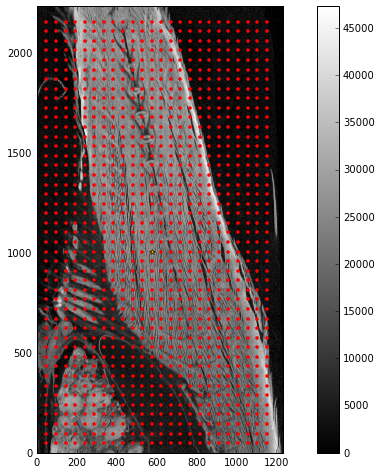

In [89]:
I = np.array(imgdata[300,:,:])
imshow(I.T, cmap=cm.gray, origin='lower')
colorbar()

ii,jj = np.meshgrid(gridi,gridj)
plot(ii,jj,'r.', gridi[exind[0]],gridj[exind[1]],'y*')

gca().set_aspect('equal')
autoscale(tight=True)

show()

Load one grid square and check the result

In [90]:
gridsz2 = (gridsize+1)//2
rng = [slice(grid11-gridsz2,grid11+gridsz2) for grid11 in [gridi[exind[0]],gridj[exind[1]]]]
I1 = I[rng].astype(float)/65536

Look at the inner and outer regions

In [91]:
np.max(I1)

0.45672607421875

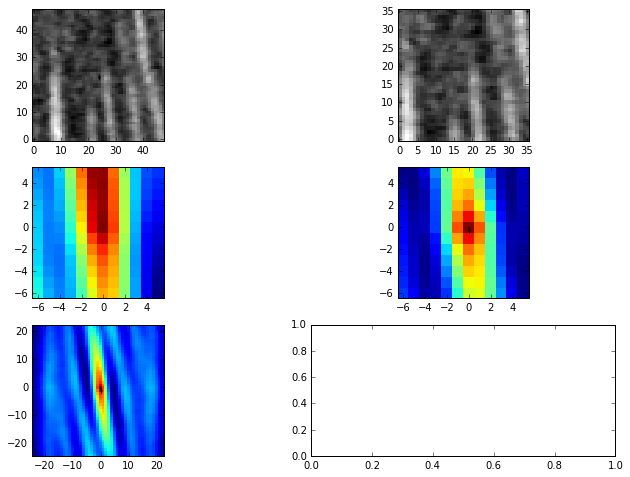

In [92]:
outsz = I1.shape
insz = (36,36)

inrng = [slice(out1//2-in1//2, out1//2-in1//2 + in1)
        for (in1,out1) in zip(insz,outsz)]
outrng = [slice(None,None,-1) for in1 in insz]

I2 = 1-I1
I2 = (I2 - np.min(I2))/np.ptp(I2)

C = signal.fftconvolve(I2[outrng],I2[inrng],mode='valid')

i = np.arange(13.0)-6.5
j = np.arange(13.0)-6.5
i,j = np.meshgrid(i,j)

vr2,w2,C2 = fibers.fiber_angle(I2, insz=(36,36), autocorrfcn=fibers.scipyautocorr, 
                               returncorr=True, window=fibers.make_window_vals(I2,window='hamming'))

vr3,w3,C3 = fibers.fiber_angle(I2, returncorr=True)

fig,ax = subplots(3,2)
ax = ax.flatten()
ax[0].imshow(I2.T,cmap=cm.gray,interpolation='nearest', origin='lower')
ax[0].quiver([24,],[24,],vr2[0,0],vr2[1,0])

ax[1].imshow(I2[inrng].T,cmap=cm.gray,interpolation='nearest', origin='lower')

ax[2].pcolormesh(i,j, C.T)
ax[2].set_aspect('equal')
ax[2].autoscale(tight=True)

ax[3].pcolormesh(i,j,C2.T)
ax[3].quiver([0,],[0,],vr2[0,0],vr2[1,0])
ax[3].set_aspect('equal')
ax[3].autoscale(tight=True)

i = np.arange(48.0)-24.5
j = np.arange(48.0)-24.5
i,j = np.meshgrid(i,j)

ax[4].pcolormesh(i,j,C3.T)
ax[4].quiver([0,],[0,],vr3[0,0],vr3[1,0])
ax[4].set_aspect('equal')
ax[4].autoscale(tight=True)

show()

In [242]:
vr1,w1,C1 = fiber_angle(I1, insz=(36,36), returncorr=True)
vr2,w2,C2 = fiber_angle(I1, insz=(36,36), returncorr=True, window='hamming')
vr3,w3,C3 = fiber_angle(I1, insz=(36,36), returncorr=True, window='kaiser', beta=1)

In [243]:
print np.real_if_close(w1)
print vr1

[ -5.06983863 -14.82279321]
[[-0.02128092 -0.99977354]
 [-0.99977354  0.02128092]]


In [244]:
print np.real_if_close(w2)
print vr2

[-1.35371049 -4.23927211]
[[-0.00276111 -0.99999619]
 [-0.99999619  0.00276111]]


In [245]:
print np.real_if_close(w2)
print vr2

[-1.35371049 -4.23927211]
[[-0.00276111 -0.99999619]
 [-0.99999619  0.00276111]]


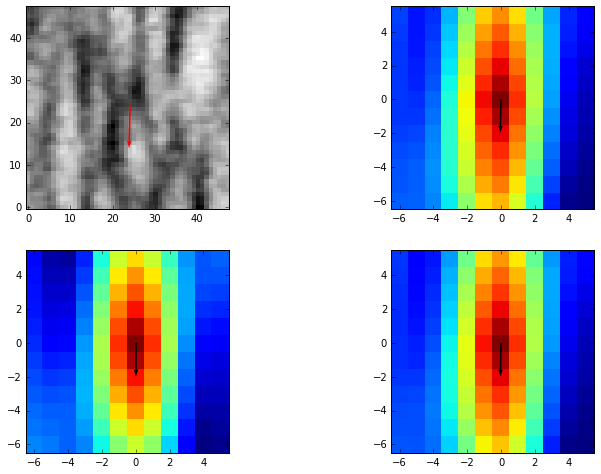

In [246]:
ctr1 = (24,24)
i = np.arange(13.0)-6.5
j = np.arange(13.0)-6.5
i,j = np.meshgrid(i,j)

fig,ax = subplots(2,2)
ax = ax.flatten()
ax[0].imshow(I1.T,cmap=cm.gray, interpolation='nearest', origin='lower')
ax[0].quiver(ctr1[0],ctr1[1],vr1[0,0],vr1[1,0],angles='xy',color='r',scale=0.1,scale_units='xy')

ax[1].pcolormesh(i,j,C1.T)
ax[1].quiver([0,],[0,],vr1[0,0],vr1[1,0],angles='xy',color='k',scale=0.5,scale_units='xy')
ax[1].set_aspect('equal')
ax[1].autoscale(tight=True)

ax[2].pcolormesh(i,j,C2.T)
ax[2].quiver([0,],[0,],vr2[0,0],vr2[1,0],angles='xy',color='k',scale=0.5,scale_units='xy')
ax[2].set_aspect('equal')
ax[2].autoscale(tight=True)

ax[3].pcolormesh(i,j,C3.T)
ax[3].quiver([0,],[0,],vr3[0,0],vr3[1,0],angles='xy',color='k',scale=0.5,scale_units='xy')
ax[3].set_aspect('equal')
ax[3].autoscale(tight=True)

show()

In [247]:
gridsz2 = (gridsize+1)//2

sz = (len(gridi),len(gridj))
eigvecs = np.zeros((2,2) + sz)
eigvals = np.zeros((2,) + sz)
insz = (36,36)

Inorm = I.astype(float)/65536
Inorm = (Inorm - np.mean(Inorm)) / np.std(Inorm)

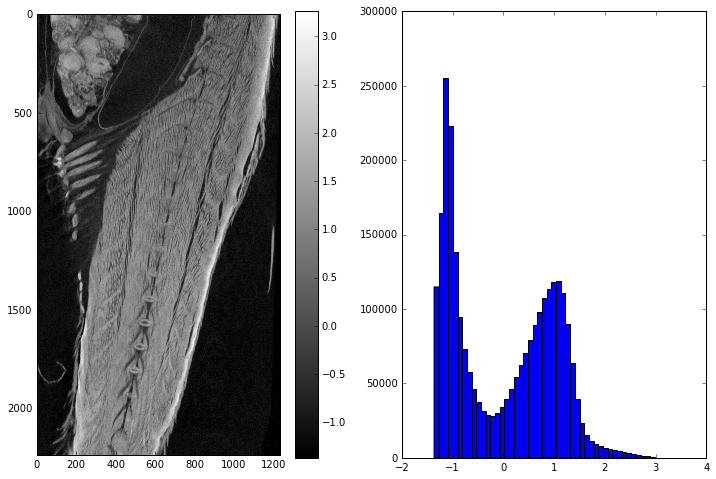

In [248]:
fig,ax = subplots(1,2)

im = ax[0].imshow(Inorm.T,cmap=cm.gray)
colorbar(im, ax=ax[0])

ax[1].hist(Inorm.flatten(),50)

show()

In [249]:
eigvals.shape

(2, 24, 45)

In [93]:
for i1, gridi1 in enumerate(gridi):
    for j1, gridj1 in enumerate(gridj):
        rng = [slice(grid11-gridsz2,grid11+gridsz2) for grid11 in [gridi1,gridj1]]

        I1 = Inorm[rng]
        if I1.size == 0:
            print "bad slice: {}".format(grid1)

        if np.mean(I1) > -0.5:
            vr1,w1 = fiber_angle(I1, insz=insz, normalize=False)

            eigvals[:,i1,j1] = real(w1)
            eigvecs[:,:,i1,j1] = vr1

NameError: name 'Inorm' is not defined

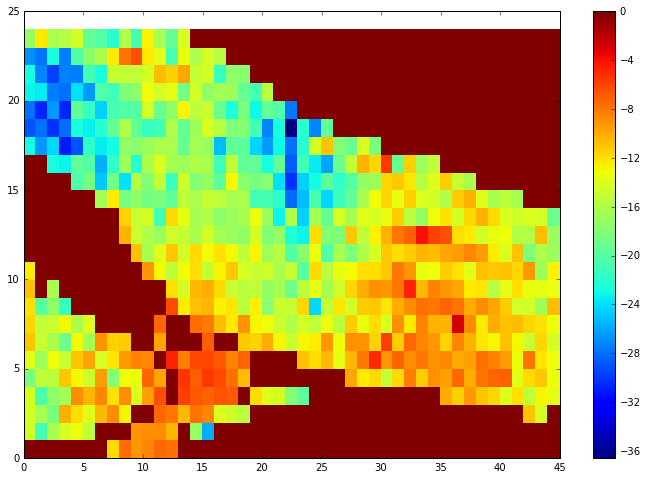

In [253]:
fig,ax = subplots()
im = ax.pcolormesh(eigvals[0,:,:])
colorbar(im,ax=ax)
show()

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


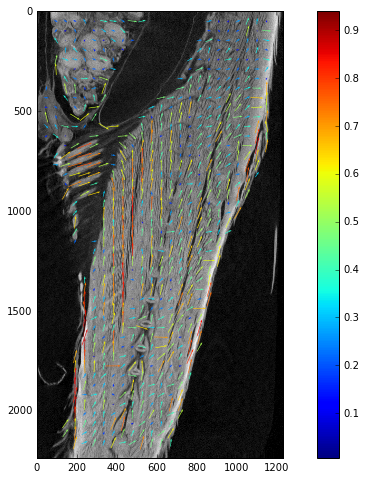

In [276]:
%matplotlib inline
rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session

ii,jj = np.meshgrid(gridi,gridj, indexing='ij')

imshow(Inorm.T,cmap=cm.gray)
vecscale = 1 - eigvals[0,:,:]/eigvals[1,:,:]
quiver(ii,jj,eigvecs[0,0,:,:]*vecscale,eigvecs[1,0,:,:]*vecscale, vecscale, pivot='mid',
      angles='xy',scale=0.05,scale_units='dots')
colorbar()
show()

In [277]:
sz = (len(gridi),len(gridj))
eigvecs2 = np.zeros((2,2) + sz)
eigvals2 = np.zeros((2,) + sz)

I2 = I.astype(float)/65536
Imn = np.mean(I2)
Istd = np.std(I2)

for i1, gridi1 in enumerate(gridi):
    for j1, gridj1 in enumerate(gridj):
        rng = [slice(grid11-gridsz2,grid11+gridsz2) for grid11 in [gridi1,gridj1]]

        I1 = I2[rng]
        if I1.size == 0:
            print "bad slice: {}".format(grid1)

        if np.mean((I1-Imn)/Istd) > -0.5:
            vr1,w1 = fiber_angle(I1, insz=insz, normalize=True)

            eigvals2[:,i1,j1] = real(w1)
            eigvecs2[:,:,i1,j1] = vr1

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


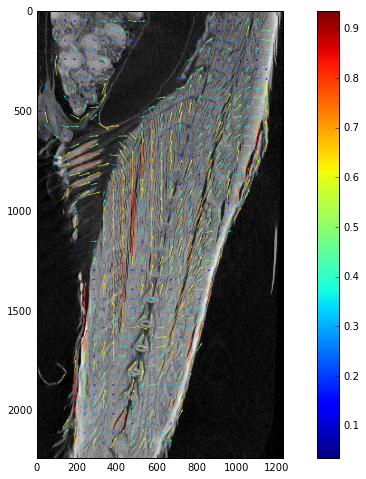

In [278]:
ii,jj = np.meshgrid(gridi,gridj, indexing='ij')

imshow(I2.T,cmap=cm.gray)
vecscale = 1 - eigvals2[0,:,:]/eigvals2[1,:,:]
quiver(ii,jj,eigvecs2[0,0,:,:]*vecscale,eigvecs2[1,0,:,:]*vecscale, vecscale, pivot='mid',
      angles='xy',scale=0.05,scale_units='dots')
colorbar()
show()